In [1]:
import time
import numpy as np
from robot_properties_talos.config import TalosConfig
from robot_properties_talos.taloswrapper import TalosRobot
from mpc.abstract_cyclic_gen1 import AbstractGaitGen

from controllers.robot_id_controller import InverseDynamicsController
from envs.pybullet_env import PyBulletEnv

import pinocchio as pin

import numpy as np
from motions.cyclic.talos_stand import still
from motions.weight_abstract import BiconvexMotionParams



<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<hpp::fcl::CollisionGeometry> already registered; second conversion method ignored.
pybullet build time: Dec  1 2021 18:33:43


In [2]:
robot = TalosConfig.buildRobotWrapper()
rmodel = robot.model
rdata = robot.data
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
## robot config and init
pin_robot = TalosConfig.buildRobotWrapper()
urdf_path = TalosConfig.urdf_path

eff_names = ["leg_right_sole1_fix_joint", "leg_right_sole2_fix_joint", "leg_right_sole3_fix_joint", "leg_right_sole4_fix_joint", \
             "leg_left_sole1_fix_joint", "leg_left_sole2_fix_joint", "leg_left_sole3_fix_joint", "leg_left_sole4_fix_joint"]
hip_names = 4*["leg_right_1_joint",] + 4*["leg_left_1_joint",]

# eff_names = ["l_leg_akx", "r_leg_akx"]
# hip_names = ["l_leg_hpz", "r_leg_hpz"]
n_eff = len(eff_names)

q0 = np.array(TalosConfig.initial_configuration)

v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])

v_des = np.array([0.0,0.0,0.0])
w_des = 0.0

plan_freq = 2 # sec
update_time = 0.0 # sec (time of lag)

In [4]:
gg = AbstractGaitGen(urdf_path, eff_names, hip_names, x0, plan_freq, q0)

robot_mass: 93.395724


In [17]:
jump = BiconvexMotionParams("Talos", "jump")

# Cnt
jump.gait_period = 1.0
jump.stance_percent = 4*[0.7,] + 4*[0.7,]
jump.gait_dt = 0.05
jump.phase_offset = 4*[0.0,] + 4*[0.0,]

# IK
jump.state_wt = np.array([1e0, 1e0, 1e0] + [1e3] * 3 + \
                    [1e3,1e5,5e3,2e2,1e3,1e3] + \
                    [1e3,1e5,5e3,2e2,1e3,1e3] + \
                    2*[1e5,] +  \
                    4*[1e5,] + 3*[1e5,] + \
                    4*[1e5,] + 3*[1e5,] \
                         + [1e0] * 3 + [1e2] * 3 + [1e2] *(pin_robot.model.nv - 6))

jump.ctrl_wt = [0, 0, 1] + [5e2, 5e2, 5e2] + [5e2] *(rmodel.nv - 6)

jump.swing_wt = [1e5, 1e4]
jump.cent_wt = [1e+7, 1e-1]
jump.step_ht = 0.1
jump.nom_ht = 0.65
jump.reg_wt = [5e-2, 1e-5]


# Dyn
jump.W_X =     np.array([1e4, 1e4, 1e+2, 1e+3, 1e+2, 2e+2, 1e+4, 5e+4, 1e4])
jump.W_X_ter = 10.*np.array([1e+5, 1e5, 1e+5, 1e+1, 1e+1, 2e+2, 1e+5, 1e+5, 1e+5])
jump.W_F = np.array(8*[1e1, 1e1,5e1])
jump.rho = 1e4

jump.ori_correction = [0.2, 0.2, 0.2]
jump.gait_horizon = 2.2
# Gains
jump.kp = np.array([1e5,1e5,1e5,1e5,1.5e3,1e3] + # left leg
                    [1e5,1e5,1e5,1e5,1.5e3,1e3] + # right leg
                    2*[1e5,] +  # torso
                    4*[2e2,] + 3*[1e1,] + # left hand 
                    4*[2e2,] + 3*[1e1,]) # right hand

jump.kd = np.array(2*[5e1,5e1,5e1,3e1,3e1,1e1] + 
              2*[1.0e1,] + 
              4*[5e0,] + 3*[1e-1,] + 
              4*[5e0,] + 3*[1e0,])

In [18]:
gg.update_gait_params(jump, 0)

Initialized Kino-Dyn planner


In [7]:
viz.viewer.jupyter_cell()

Maximum iterations reached 
Final norm: 0.00142416
Cost Time : 0.011243343353271484
Solve Time :  0.1310710906982422


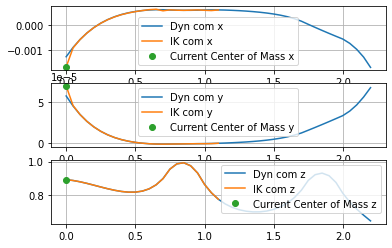

IndexError: index 1999 is out of bounds for axis 0 with size 1050

In [19]:
sim_t = 0.0
sim_dt = 0.001
index = 0
pln_ctr = 0
q = q0
v = v0

for o in range(1):
    xs, us, f = gg.optimize(q, v, sim_t, v_des, w_des)
    gg.plot(q, v)
    for ind in range(len(xs)):
        viz.display(xs[ind][:robot.model.nq])
#         time.sleep(0.001)
    sim_t += plan_freq
    q = xs[int(plan_freq/sim_dt)-1][0:pin_robot.model.nq].copy()
    v = xs[int(plan_freq/sim_dt)-1][pin_robot.model.nq:].copy()


In [9]:
q

array([-3.74911192e-03, -8.88302835e-05,  9.31478794e-01,  6.69050771e-05,
       -8.74723453e-02, -1.94304497e-05,  9.96166946e-01, -3.28885942e-03,
       -4.70694572e-05, -3.87559325e-01,  1.36986833e+00, -8.17776334e-01,
       -2.59209948e-03,  3.32336712e-03,  3.63655989e-05, -3.87607362e-01,
        1.36996903e+00, -8.17832619e-01,  2.01087611e-03,  1.14057379e-05,
       -7.41367664e-03,  2.55815584e-01,  1.74719439e-01, -8.29161192e-06,
       -5.31355492e-01, -7.39043142e-05,  6.81576626e-05, -1.14132548e-03,
       -2.55805018e-01, -1.74698342e-01,  1.57155548e-05, -5.31324298e-01,
        7.60349300e-05, -6.62982161e-05, -1.10697680e-03])

In [10]:
i = 0
for names in rmodel.names[2:]:
    print(i, names)
    i += 1
print(i, rmodel.nq-7)

0 leg_left_1_joint
1 leg_left_2_joint
2 leg_left_3_joint
3 leg_left_4_joint
4 leg_left_5_joint
5 leg_left_6_joint
6 leg_right_1_joint
7 leg_right_2_joint
8 leg_right_3_joint
9 leg_right_4_joint
10 leg_right_5_joint
11 leg_right_6_joint
12 torso_1_joint
13 torso_2_joint
14 arm_left_1_joint
15 arm_left_2_joint
16 arm_left_3_joint
17 arm_left_4_joint
18 arm_left_5_joint
19 arm_left_6_joint
20 arm_left_7_joint
21 arm_right_1_joint
22 arm_right_2_joint
23 arm_right_3_joint
24 arm_right_4_joint
25 arm_right_5_joint
26 arm_right_6_joint
27 arm_right_7_joint
28 28


In [11]:
rmodel.getFrameId("leg_right_sole_fix_joint")

133

In [12]:
rmodel

Nb joints = 30 (nq=35,nv=34)
  Joint 0 universe: parent=0
  Joint 1 root_joint: parent=0
  Joint 2 leg_left_1_joint: parent=1
  Joint 3 leg_left_2_joint: parent=2
  Joint 4 leg_left_3_joint: parent=3
  Joint 5 leg_left_4_joint: parent=4
  Joint 6 leg_left_5_joint: parent=5
  Joint 7 leg_left_6_joint: parent=6
  Joint 8 leg_right_1_joint: parent=1
  Joint 9 leg_right_2_joint: parent=8
  Joint 10 leg_right_3_joint: parent=9
  Joint 11 leg_right_4_joint: parent=10
  Joint 12 leg_right_5_joint: parent=11
  Joint 13 leg_right_6_joint: parent=12
  Joint 14 torso_1_joint: parent=1
  Joint 15 torso_2_joint: parent=14
  Joint 16 arm_left_1_joint: parent=15
  Joint 17 arm_left_2_joint: parent=16
  Joint 18 arm_left_3_joint: parent=17
  Joint 19 arm_left_4_joint: parent=18
  Joint 20 arm_left_5_joint: parent=19
  Joint 21 arm_left_6_joint: parent=20
  Joint 22 arm_left_7_joint: parent=21
  Joint 23 arm_right_1_joint: parent=15
  Joint 24 arm_right_2_joint: parent=23
  Joint 25 arm_right_3_joint: 

In [13]:
rmodel.nq - 7

28